# Title: What is the Myers–Briggs Type Indicator (MBTI) Associated with the Type of Music?

Link to the dataset: https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(rsample)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Introduction:
The Myers-Briggs Type Indicator (MBTI), based on the theory of psychological types described by C. G. Jung, describes personality across four axes with a total of sixteen distinct combinations (The Myers & Briggs Foundation). Research shows that musical taste is related to personality, but little evidence demonstrates how predictable musical features are. 

This study attempts to classify the MBTI associated with the given musical characteristics of a song using a k-nearest neighbor classification model. The dataset, titled "Spotify MBTI Playlists", contains aggregated information on eleven different musical features for a Spotify playlist on each row.

### Preliminary exploratory data analysis:

The dataset can be read directly as a csv file and it is tidy data. However, to maximize predictability, the key count is combined into major and minor columns (see method for more information).

In [2]:
spotify_mbti <- read_csv("combined_mbti_df.csv") |>
    mutate(mbti = as_factor(mbti))
spotify_mbti

Rows: 4081 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): mbti, function_pair
dbl (44): danceability_mean, danceability_stdev, energy_mean, energy_stdev, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,NF,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,⋯,2,2,1,4,0,0,0,0,0,0
INFP,NF,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,1,2,1,4,1,1,1,1,0,0
INFP,NF,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,⋯,0,1,1,3,1,0,0,1,2,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,SJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,⋯,1,1,2,0,1,0,0,0,0,1
ESTJ,SJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,⋯,2,0,3,1,0,1,2,2,1,3
ESTJ,SJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,⋯,2,0,4,1,2,0,3,1,2,2


In [3]:
# remove function_pair, mutate columns to major and minor
spotify_mbti_cleaned <- spotify_mbti |>
    select(-function_pair) |>
    mutate(major_count = CMajor_count + `C#/DbMajor_count` + DMajor_count +
           `D#_EbMajor_count` + EMajor_count + FMajor_count + GMajor_count +
           `G#/AbMajor_count` + AMajor_count + BMajor_count + `A#/BbMajor_count` +
           `F#/GbMajor_count`,
           minor_count = Cminor_count + `C#/Dbminor_count` + Eminor_count +
          Fminor_count + `F#/Gbminor_count` + `G#/Abminor_count` + 
          Aminor_count + `A#/Bbminor_count` + Dminor_count + `D#_Ebminor_count` +
          Gminor_count + Bminor_count) |>
    select(mbti:instrumentalness_stdev, major_count, minor_count)
spotify_mbti_cleaned

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,0.06734091,⋯,0.1634023,0.0862659,0.4488841,0.2217635,120.9548,32.16578,0.01997099,0.08180459,29,15
INFP,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,0.07427273,⋯,0.1545424,0.1124957,0.4476030,0.2160687,131.8712,33.21601,0.06104086,0.17755873,21,12
INFP,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,0.27254600,⋯,0.2645200,0.2080966,0.2650300,0.1705175,128.2060,26.92719,0.25035756,0.33180466,29,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.0029272391,9,7
ESTJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,0.09537600,⋯,0.1564140,0.1230124,0.5587180,0.2778599,125.0429,29.28428,0.0389386528,0.1495546238,27,23
ESTJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,0.10697778,⋯,0.1925044,0.1268794,0.5557111,0.2316916,123.6504,27.03963,0.0001314116,0.0005088235,25,20


In [4]:
glimpse(spotify_mbti_cleaned)

Rows: 4,081
Columns: 23
$ mbti                   <fct> INFP, INFP, INFP, INFP, INFP, INFP, INFP, INFP,…
$ danceability_mean      <dbl> 0.5578409, 0.5876364, 0.6770000, 0.5170000, 0.5…
$ danceability_stdev     <dbl> 0.15501057, 0.13564425, 0.12800941, 0.16947739,…
$ energy_mean            <dbl> 0.5533250, 0.5562727, 0.8512800, 0.5134119, 0.4…
$ energy_stdev           <dbl> 0.22517799, 0.19164196, 0.12833646, 0.25834492,…
$ loudness_mean          <dbl> -8.352591, -8.215697, -5.046100, -10.172833, -1…
$ loudness_stdev         <dbl> 3.273317, 3.356867, 2.180554, 4.935140, 5.68517…
$ mode_mean              <dbl> 0.6590909, 0.6363636, 0.5800000, 0.7857143, 0.8…
$ mode_stdev             <dbl> 0.4794950, 0.4885042, 0.4985694, 0.4152997, 0.3…
$ speechiness_mean       <dbl> 0.06734091, 0.07427273, 0.27254600, 0.05150952,…
$ speechiness_stdev      <dbl> 0.06108258, 0.08338823, 0.17601286, 0.03391090,…
$ acousticness_mean      <dbl> 0.29346909, 0.34143394, 0.05808475, 0.44216304,…
$ acousticness_s

In [5]:
# report how many rows have missing data
na_rows <- spotify_mbti_cleaned[!complete.cases(spotify_mbti_cleaned), ]
na_rows
nrow(na_rows)

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ESFP,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.002927239,9,NA
ESFP,0.5913400,0.1496571,0.6295800,0.2106427,-6.534280,2.689405,0.6800000,0.4712121,0.06671000,⋯,0.1736960,0.1375849,0.5029780,0.2514175,120.6514,25.24660,0.0108525478,0.043100780,34,NA
ISTJ,0.5542414,0.1087355,0.6090448,0.2363416,-7.820414,3.709420,0.7931034,0.4122508,0.08745862,⋯,0.1741276,0.1177350,0.5095172,0.2137523,122.1670,28.80523,0.1356378224,0.295098108,23,NA
ISTJ,0.5528800,0.1257076,0.4941400,0.2514677,-9.357180,3.848256,0.6800000,0.4712121,0.05540600,⋯,0.1869280,0.1494879,0.5156200,0.2167743,120.1463,24.36730,0.0123044960,0.050895117,34,NA


[1] 4

 ### There are 4 na values in the minor_count column, so we should remove these 4 rows

In [6]:
# remove these 4 rows with na values
spotify_mbti_cleaned_na_removal <- spotify_mbti_cleaned |>
    filter(!is.na(minor_count))

spotify_mbti_cleaned_na_removal

nrow(spotify_mbti_cleaned_na_removal)

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,0.06734091,⋯,0.1634023,0.0862659,0.4488841,0.2217635,120.9548,32.16578,0.01997099,0.08180459,29,15
INFP,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,0.07427273,⋯,0.1545424,0.1124957,0.4476030,0.2160687,131.8712,33.21601,0.06104086,0.17755873,21,12
INFP,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,0.27254600,⋯,0.2645200,0.2080966,0.2650300,0.1705175,128.2060,26.92719,0.25035756,0.33180466,29,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.0029272391,9,7
ESTJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,0.09537600,⋯,0.1564140,0.1230124,0.5587180,0.2778599,125.0429,29.28428,0.0389386528,0.1495546238,27,23
ESTJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,0.10697778,⋯,0.1925044,0.1268794,0.5557111,0.2316916,123.6504,27.03963,0.0001314116,0.0005088235,25,20


[1] 4077

### na values have been removed, now let's split the data into train and test sets

In [7]:
set.seed(1)

spotify_split <- initial_split(spotify_mbti_cleaned_na_removal, prop = 0.75, strata = mbti)  
spotify_mbti_train <- training(spotify_split)   
spotify_mbti_test <- testing(spotify_split)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.

In [8]:
# report number of observations in each class
observation_count <- spotify_mbti_train |>
    group_by(mbti) |>
    summarize(count = n())
observation_count

mbti,count
<fct>,<int>
INFP,231
ENFP,225
INFJ,241
⋮,⋮
ESFJ,84
ISTJ,143
ESTJ,82


In [9]:
# report means of the predictor variables
means_table <- spotify_mbti_train |>
    summarize(across(danceability_mean:minor_count, mean, na.rm = TRUE))

glimpse(means_table)

Rows: 1
Columns: 22
$ danceability_mean      <dbl> 0.5937052
$ danceability_stdev     <dbl> 0.1372644
$ energy_mean            <dbl> 0.6351733
$ energy_stdev           <dbl> 0.1753721
$ loudness_mean          <dbl> -7.130696
$ loudness_stdev         <dbl> 2.869923
$ mode_mean              <dbl> 0.6026921
$ mode_stdev             <dbl> 0.4713741
$ speechiness_mean       <dbl> 0.0782699
$ speechiness_stdev      <dbl> 0.06497499
$ acousticness_mean      <dbl> 0.2505405
$ acousticness_stdev     <dbl> 0.2391013
$ liveness_mean          <dbl> 0.1808428
$ liveness_stdev         <dbl> 0.1309472
$ valence_mean           <dbl> 0.4752963
$ valence_stdev          <dbl> 0.2111479
$ tempo_mean             <dbl> 121.892
$ tempo_stdev            <dbl> 28.71042
$ instrumentalness_mean  <dbl> 0.07774629
$ instrumentalness_stdev <dbl> 0.1475589
$ major_count            <dbl> 24.80667
$ minor_count            <dbl> 16.30422


In [10]:
# report how many rows have missing data
na_rows <- spotify_mbti_train[!complete.cases(spotify_mbti_train), ]
na_rows
nrow(na_rows)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

### There are 0 rows with na values in the training data set

In [11]:
# check NA value
filter(spotify_mbti_train, danceability_mean == 0.5853125)

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ESFJ,0.5853125,0.1819083,0.694375,0.1736364,-5.307063,1.531874,0.5625,0.5123475,0.09024375,⋯,0.1578,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.002927239,9,7
ISTJ,0.5853125,0.1819083,0.694375,0.1736364,-5.307063,1.531874,0.5625,0.5123475,0.09024375,⋯,0.1578,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.002927239,9,7
ESTJ,0.5853125,0.1819083,0.694375,0.1736364,-5.307063,1.531874,0.5625,0.5123475,0.09024375,⋯,0.1578,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.002927239,9,7


Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [12]:
spotify_mbti_train

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,0.06734091,⋯,0.1634023,0.08626590,0.4488841,0.2217635,120.9548,32.16578,0.01997099,0.08180459,29,15
INFP,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,0.27254600,⋯,0.2645200,0.20809663,0.2650300,0.1705175,128.2060,26.92719,0.25035756,0.33180466,29,21
INFP,0.5170000,0.1694774,0.5134119,0.2583449,-10.172833,4.935140,0.7857143,0.4152997,0.05150952,⋯,0.1526452,0.09595586,0.3378452,0.2118900,120.5936,34.33522,0.21092715,0.29434621,33,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.0029272391,9,7
ESTJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,0.09537600,⋯,0.1564140,0.1230124,0.5587180,0.2778599,125.0429,29.28428,0.0389386528,0.1495546238,27,23
ESTJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,0.10697778,⋯,0.1925044,0.1268794,0.5557111,0.2316916,123.6504,27.03963,0.0001314116,0.0005088235,25,20


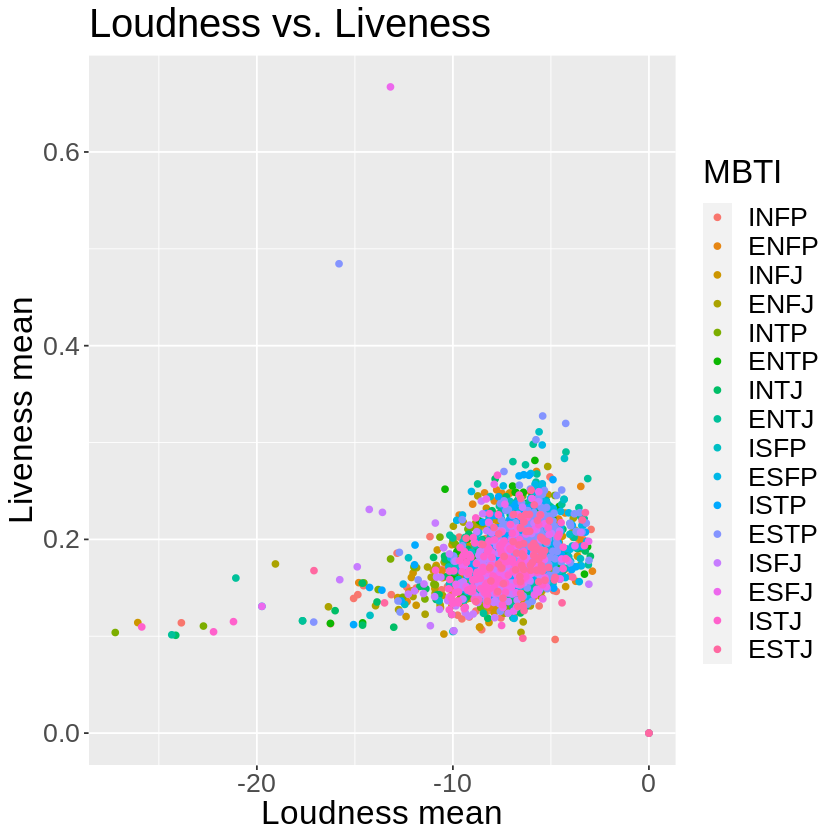

In [13]:
# Plot loudness vs liveness
loudness_liveness_mean <- spotify_mbti_train |>  
    ggplot(aes(x = loudness_mean, 
               y = liveness_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Loudness mean",
             y = "Liveness mean",
            colour = 'MBTI') +
    ggtitle("Loudness vs. Liveness") +
    theme(text = element_text(size = 20))
loudness_liveness_mean

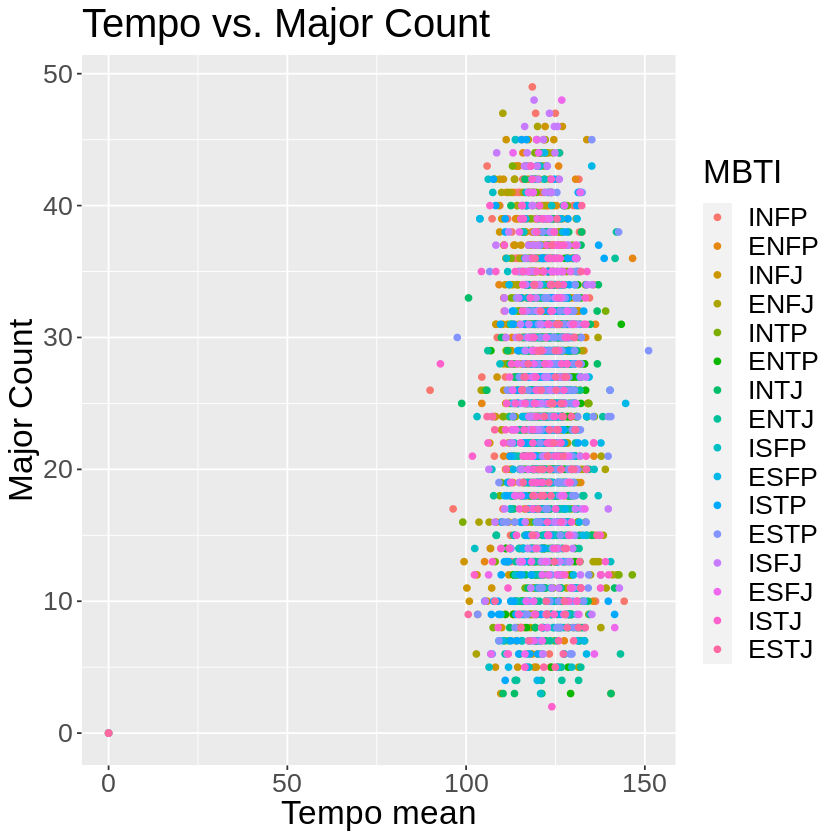

In [14]:
# Plot tempo vs major count
tempo_major_count <- spotify_mbti_train |>  
    ggplot(aes(x = tempo_mean, 
               y = major_count, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Tempo mean",
             y = "Major Count",
            colour = 'MBTI') +
    ggtitle("Tempo vs. Major Count") +
    theme(text = element_text(size = 20))
tempo_major_count

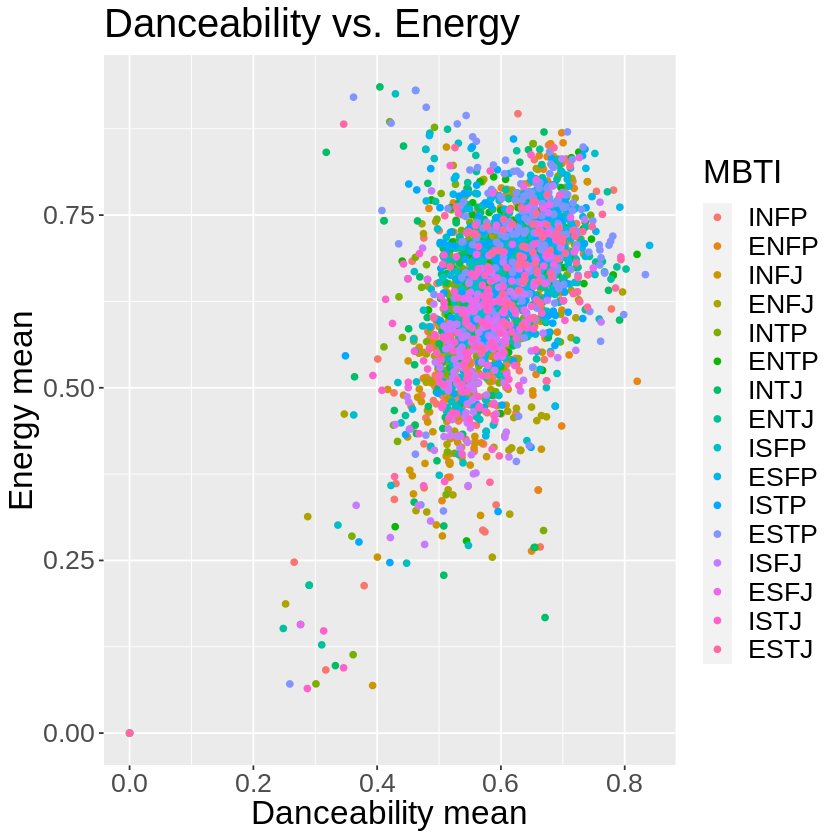

In [15]:
# Plot danceability vs energy
danceability_energy_mean <- spotify_mbti_train |>  
    ggplot(aes(x = danceability_mean, 
               y = energy_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Danceability mean",
             y = "Energy mean",
            colour = 'MBTI') +
    ggtitle("Danceability vs. Energy") +
    theme(text = element_text(size = 20))
danceability_energy_mean

### Methods:
We will conduct our data analysis by using the K-nearest neighbor classification to predict MBTI from the audio quality features of Spotify playlists. We will use all variables from danceability_mean to instrumentalness_stdev (removing function_pair as it is too repetitive and unnecessary), and to decrease the number of predictable variables, we will need to put all the majors into one column and all the minors into another. 

One way we will visualize the results is by visualizing the confusion matrix as a bar plot, where we will plot the number of correctly identified MBTI types against the number of incorrectly identified MBTI types.

### Expected outcomes and significance:
It is difficult to predict our findings with confidence by analyzing music features and MBTI because music preference is complex and highly unique. However, we may find correlations between MBTI and musical features. Using these trends we hope to predict an individual’s MBTI type based on the music they enjoy.

Despite its controversy in psychology community due to its inability to fully represent the intricacies of human personality, our project may prove to be useful in developing a general understanding of the relationship between music and personality. This knowledge may be purposeful in many areas, including but not limited to:
* Personal development: Individuals may utilize the conclusions of the project to make well-informed decisions on musical choices to enhance mood and quality of life.
* Advertisement: A better understanding of the relationship between personality and music type allow companies to market better, such as personalized advertisements for musical merchandise or specially-made playlists.
* Music recommendation algorithms: Streaming platforms may follow personality and music trends to suggest targeted music to users.

There are several questions that our project could lead to, such as:
* Can musical preferences suggest personality traits beyond MBTI types?
* Is personality a major influence for musical preference? If not, what are the factors?

Sources:
* https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/
* https://www.verywellmind.com/music-and-personality-2795424